# Solving photoacoustic least squares with IterativeSolvers.jl 

In this tutorial, we will illustrate how to use Photoacoustic.jl in tandem with the solvers in IterativeSolvers.jl to solve inverse problems. Our illustration will be a photoacoustic inverse problem where the observe data has been generated by a photoacoustic operator plus corrupting noise:
$y = Ax^{\star} + \varepsilon$ where we assume the noise comes from a standard Normal distribution. We want to solve this inverse problem in the least squares sense:
$$\hat x = \mathrm{argmin}_{x} \, \|Ax - y\|_2^2$$

To use the solvers in IterativeSolver.jl all we need is to define matrix vector products $Av$ and adjoint matrix vector products $A^{\top}v$. These are both implemented in PhotoAcoustic.jl.

In [1]:
using PhotoAcoustic
using JUDI
using PyPlot
using LinearAlgebra

┌ Info: Precompiling PhotoAcoustic [86b14aa7-fcb7-4836-b4c7-056f45a9c77b]
└ @ Base loading.jl:1423
ERROR: LoadError: ArgumentError: Package PhotoAcoustic does not have FFTResampling in its dependencies:
- If you have PhotoAcoustic checked out for development and have
  added FFTResampling as a dependency but haven't updated your primary
  environment's manifest file, try `Pkg.resolve()`.
- Otherwise you may need to report an issue with PhotoAcoustic
Stacktrace:
  [1] require(into::Module, mod::Symbol)
    @ Base ./loading.jl:980
  [2] include(mod::Module, _path::String)
    @ Base ./Base.jl:418
  [3] include(x::String)
    @ PhotoAcoustic ~/.julia/dev/PhotoAcoustic/src/PhotoAcoustic.jl:1
  [4] top-level scope
    @ ~/.julia/dev/PhotoAcoustic/src/PhotoAcoustic.jl:30
  [5] include
    @ ./Base.jl:418 [inlined]
  [6] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Bas

LoadError: Failed to precompile PhotoAcoustic [86b14aa7-fcb7-4836-b4c7-056f45a9c77b] to /Users/rafaelorozco/.julia/compiled/v1.7/PhotoAcoustic/jl_h41Ahq.

## Define photoacoustic simulation

In [71]:
# Set up model structure
n = (128, 128)   # (x,y,z) or (x,z)
d = (0.08f0, 0.08f0)
o = (0., 0.)

# Constant water velocity [mm/microsec]
v = 1.5*ones(Float32,n) 
m = (1f0 ./ v).^2 # JUDI is parameterized by slowness

# Setup model structure
model = Model(n, d, o, m;)

# Set up receiver geometry (receivers on top of model)
nxrec = 32
xrec = range(0, stop=d[1]*(n[1]-1), length=nxrec)
yrec = [0f0]
zrec = range(0, stop=0, length=nxrec)

xrec_1 = range(d[1], stop=d[1] length=nxrec)
zrec_1 = range(0, stop=d[1]*(n[1]-1), length=nxrec)

xrec = vcat(xrec,xrec_1)
zrec = vcat(zrec,zrec_1)

# receiver sampling and recording time
time = 10 #[microsec] 
dt = calculate_dt(model) / 2    

# Set up receiver structure
recGeometry = Geometry(xrec, yrec, zrec; dt=dt, t=time, nsrc=1)

# Setup operators
opt = Options(dt_comp=dt)
F = judiModeling(model; options=opt)
A = judiPhoto(F, recGeometry;)

JUDI forward{Float32} propagator (z * x) -> (src * rec * time)

## Make observed data 
We make observed data by running the linear photoacoustic simulation represented by $A$ and then adding gaussian noise to the data. 

In [ ]:
using JLD2
file_vessels = load("$(PhotoAcoustic.PhotoAcoustic_data)/vessels_2d.jld")
vessels = file_vessels["vessels"]
x = judiInitialState(vessels)

As ground truth we use a realistic model of a blood vessel derived from lung ct scans. 

Operator `forward` ran in 0.47 s


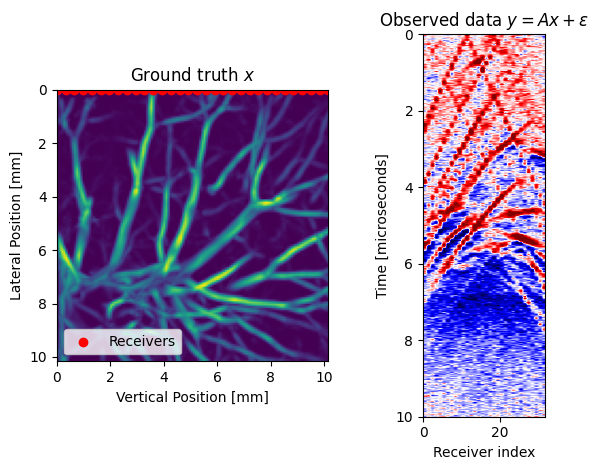

In [85]:
# Run forward model and add noise
y = A*x 
y = y + judiVector(recGeometry, 0.05f0*randn(Float32, size(y.data[1])))

data_extent = (0, nxrec, time,0)
model_extent = (0,(n[1]-1)*d[1],(n[2]-1)*d[2],0)

subplot(1,2,1); title(L"Ground truth $x$")
imshow(x.data[1]';extent=model_extent);
xlabel("Vertical Position [mm]");ylabel("Lateral Position [mm]");
PyPlot.scatter(xrec, zrec;color="red",label="Receivers")
legend(loc="lower left")

subplot(1,2,2); title(L"Observed data $y=Ax+\epsilon$")
imshow(y.data[1]; cmap="seismic", extent=data_extent, aspect=10,vmax=0.2,vmin=-0.2)
xlabel("Receiver index");ylabel("Time [microseconds]");


tight_layout()

## Iteratively solve using different algorithms:

In [80]:
using IterativeSolvers

x_adj = A'*y
x_lsqr = 0f0 .* x

maxiters = 20
_, history_lsqr = lsqr!(x_lsqr, A, y; maxiter=maxiters, verbose=true, log=true)

=== lsqr ===
iter	resnorm		  anorm		  cnorm		  rnorm
  1	1.27e+00	8.01e-01	2.86e+00	7.71e-01
  2	1.11e+00	3.54e-01	1.02e+00	6.78e-01
  3	9.99e-01	2.07e-01	6.01e-01	6.09e-01
  4	9.35e-01	1.20e-01	4.36e-01	5.70e-01
  5	8.93e-01	8.66e-02	3.48e-01	5.44e-01
  6	8.69e-01	6.32e-02	2.89e-01	5.30e-01
  7	8.50e-01	5.03e-02	2.46e-01	5.18e-01
  8	8.38e-01	3.87e-02	2.14e-01	5.11e-01
  9	8.31e-01	2.55e-02	1.90e-01	5.06e-01
 10	8.28e-01	2.01e-02	1.70e-01	5.04e-01
 11	8.26e-01	1.20e-02	1.54e-01	5.03e-01
 12	8.25e-01	8.24e-03	1.41e-01	5.03e-01
 13	8.24e-01	6.49e-03	1.31e-01	5.02e-01
 14	8.24e-01	5.59e-03	1.21e-01	5.02e-01
 15	8.23e-01	5.33e-03	1.12e-01	5.02e-01
 16	8.23e-01	5.73e-03	1.02e-01	5.02e-01
 17	8.22e-01	5.69e-03	9.44e-02	5.01e-01
 18	8.22e-01	5.22e-03	8.75e-02	5.01e-01
 19	8.21e-01	4.36e-03	8.19e-02	5.01e-01
 20	8.21e-01	3.64e-03	7.73e-02	5.01e-01



Operator `adjoint` ran in 0.54 s
Operator `Kernel` ran in 0.01 s
Operator `forward` ran in 0.41 s
Operator `adjoint` ran in 0.42 s
Operator `Kernel` ran in 0.01 s
Operator `forward` ran in 0.47 s
Operator `adjoint` ran in 0.61 s
Operator `Kernel` ran in 0.01 s
Operator `forward` ran in 0.56 s
Operator `adjoint` ran in 0.49 s
Operator `Kernel` ran in 0.01 s
Operator `forward` ran in 0.47 s
Operator `adjoint` ran in 0.53 s
Operator `Kernel` ran in 0.01 s
Operator `forward` ran in 0.47 s
Operator `adjoint` ran in 0.44 s
Operator `Kernel` ran in 0.01 s
Operator `forward` ran in 0.41 s
Operator `adjoint` ran in 0.42 s
Operator `Kernel` ran in 0.01 s
Operator `forward` ran in 0.42 s
Operator `adjoint` ran in 0.48 s
Operator `Kernel` ran in 0.01 s
Operator `forward` ran in 0.40 s
Operator `adjoint` ran in 0.42 s
Operator `Kernel` ran in 0.01 s
Operator `forward` ran in 0.46 s
Operator `adjoint` ran in 1.44 s
Operator `Kernel` ran in 0.01 s
Operator `forward` ran in 1.18 s
Operator `adjoint` r

(judiInitialState{Float32} with 1 sources, Converged after 20 iterations.)

## Plotting convergence history

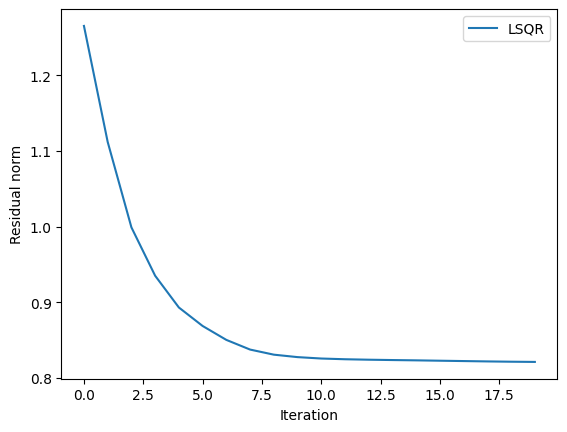

PyObject <matplotlib.legend.Legend object at 0x15aa35280>

In [81]:
plot(history_lsqr[:resnorm];label="LSQR")
ylabel("Residual norm"); xlabel("Iteration"); legend()

## Plotting results
We can visualize our results and interpret that the adjoint solution can resolve the main structures but has wrong amplitudes. A least sqeares method such as LSQR will help bring amplitudes to the correct level. Also observe that both the adjoint and LSQR can resolve structures that are perpendicular to the receiver geometry but miss vertical vessels. This is because the vertical events are in the null space of the operator.  

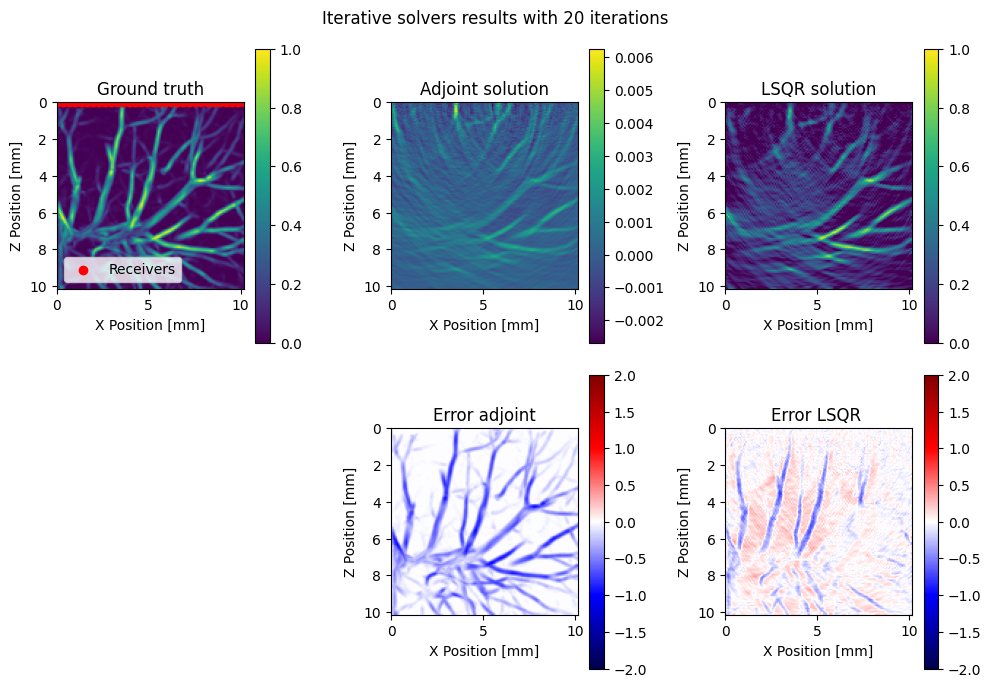

In [82]:
fig = figure(figsize=(10,7))
suptitle("Iterative solvers results with $(maxiters) iterations")

subplot(2,3,1); title("Ground truth") 
imshow(x.data[1]';extent=model_extent, vmin=0,vmax=1)
ylabel("Z Position [mm]";); xlabel("X Position [mm]"; ); colorbar()
PyPlot.scatter(xrec, zrec;color="red",label="Receivers")
legend(loc="lower left")

subplot(2,3,2);  title("Adjoint solution")
imshow(x_adj.data[1]';extent=model_extent)
ylabel("Z Position [mm]";); xlabel("X Position [mm]"; ); colorbar()

subplot(2,3,3); title("LSQR solution")
imshow(x_lsqr.data[1]';extent=model_extent, vmin=0,vmax=1)
ylabel("Z Position [mm]";); xlabel("X Position [mm]"; ); colorbar()

subplot(2,3,5);  title("Error adjoint")
imshow(x_adj.data[1]' - x.data[1]';cmap="seismic", extent=model_extent, vmin=-2, vmax=2)
ylabel("Z Position [mm]";); xlabel("X Position [mm]"; ); colorbar()

subplot(2,3,6); title("Error LSQR ")
imshow(x_lsqr.data[1]'- x.data[1]';cmap="seismic",extent=model_extent, vmin=-2, vmax=2)
ylabel("Z Position [mm]";); xlabel("X Position [mm]"; ); colorbar()

tight_layout()